**1. Installation**

In [13]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import tensorflow as tf

import numpy as np
import pandas as pd
import os

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

**2. Data Preprocessing**

In [5]:
labels = pd.read_csv('../input/semantic-drone-dataset/class_dict_seg.csv')
labels

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [6]:
labels.name

0       unlabeled
1      paved-area
2            dirt
3           grass
4          gravel
5           water
6           rocks
7            pool
8      vegetation
9            roof
10           wall
11         window
12           door
13          fence
14     fence-pole
15         person
16            dog
17            car
18        bicycle
19           tree
20      bald-tree
21      ar-marker
22       obstacle
23    conflicting
Name: name, dtype: object

**3. Visualization of class colors**

In [9]:
def print_label_colors():
  #`This procedure just generates the label and its colours for references`

    for index,label in enumerate(labels.name):
        plt.subplot(6,4,index+1)
        (r,g,b)=labels.iloc[index].values[1:]
        img_ = np.array([[[r,g,b],[r,g,b],[r,g,b],[r,g,b]]])
        plt.title(label)
        plt.imshow(img_)
        plt.axis('off')

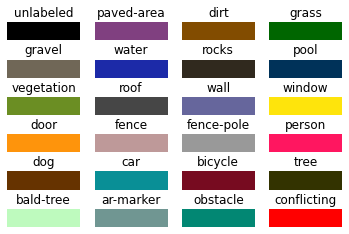

In [10]:
print_label_colors()

**4. Images Pre-processing**

In [11]:
inp_dir = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images'
mask_dir = '../input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks'

In [14]:
inp_list = os.listdir(inp_dir)
mask_list=os.listdir(mask_dir)
inp_list.sort()
mask_list.sort()
inp_img_list = [os.path.join(inp_dir,i) for i in inp_list]
mask_list = [os.path.join(mask_dir,i) for i in mask_list]

**5. Visualization of some images and their mask images**

In [15]:
def plt_image_and_mask_by_path(img_list,mask_lst,n=3):
  for i in range(3):
    img1=imageio.imread(img_list[i])
    mask1=imageio.imread(mask_lst[i])
    _,arr = plt.subplots(1,2,figsize=(10,10))
    arr[0].imshow(img1)
    arr[0].axis('off')
    arr[1].imshow(mask1)
    arr[1].axis('off')

In [16]:
def plt_image_and_mask_with_dataset(image_ds,mask_ds):
    _,arr = plt.subplots(1,2,figsize=(10,10))
    arr[0].imshow(tf.keras.preprocessing.image.array_to_img(image_ds))
    arr[0].axis('off')
    arr[1].imshow(tf.keras.preprocessing.image.array_to_img(mask_ds))
    arr[1].axis('off')

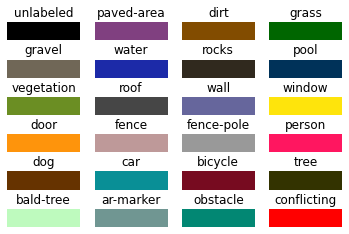

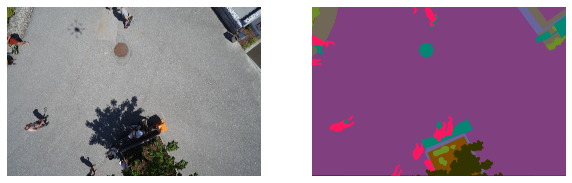

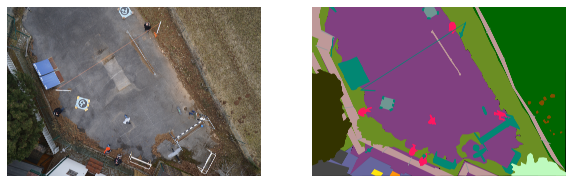

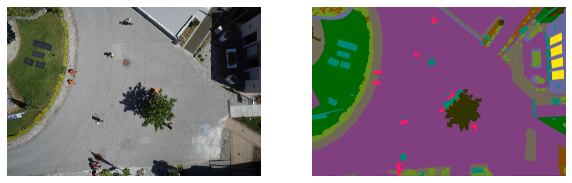

In [17]:
print_label_colors()
plt_image_and_mask_by_path(inp_img_list,mask_list,3)

**6. Convert to pixel arrays**

In [18]:
image_names  = tf.constant(inp_img_list)
mask_names = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_names,mask_names))
for image,mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/000.jpg', shape=(), dtype=string)
tf.Tensor(b'../input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/000.png', shape=(), dtype=string)


2022-10-03 05:50:44.276694: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
def process_path(image_,mask_):
    img = tf.io.read_file(image_)
    img = tf.image.decode_png(img,channels=3)
    img = tf.image.convert_image_dtype(img,tf.float32)
    
    mask = tf.io.read_file(mask_)
    mask = tf.image.decode_png(mask,channels=3)
    ## take max of each pixel vector along channels axis, but keep the dimensions
    ## this is to make training faster(at least compared to 3 channeled mask images)
    ## once we do this , true mask images and new mask images differ by colors of each class
    ## and images are reduced in quality
    mask = tf.math.reduce_max(mask,axis=-1,keepdims=True)
    return img,mask

def process(image,mask):
    '''
    reduce the image size
    '''
    inp_image = tf.image.resize(image,(96,128),method='nearest')
    inp_mask = tf.image.resize(mask,(96,128),method='nearest')   
    return inp_image,inp_mask
    
image_ds = dataset.map(process_path)
processed_images_ds = image_ds.map(process)

2022-10-03 05:51:26.151254: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


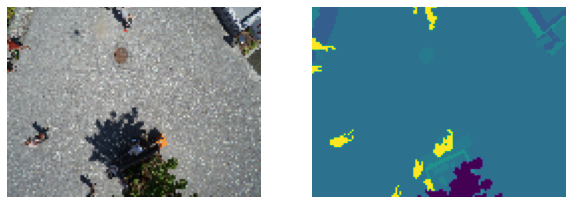

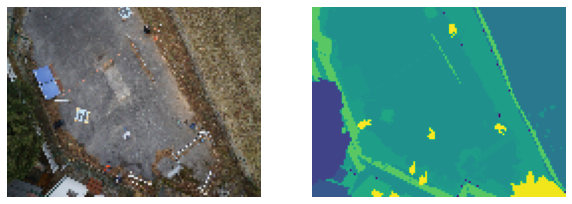

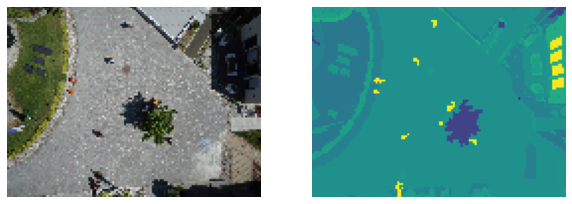

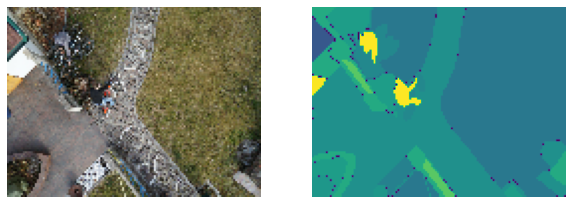

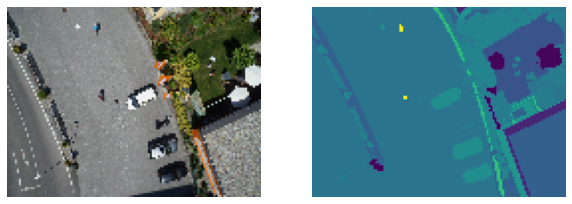

In [21]:
for image,mask in processed_images_ds.take(5):
    plt_image_and_mask_with_dataset(image,mask)

**7. UNET Architecture (we get it from GitHub and also you can find it from Coursera)**

In [22]:
# UNQ_C1
# GRADED FUNCTION: conv_block
def conv_block(inputs=None, n_filters=64, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = Conv2D(n_filters, # Number of filters
                  kernel_size=3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         ### START CODE HERE
        conv = Dropout(dropout_prob)(conv)
         ### END CODE HERE
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        ### END CODE HERE
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [23]:
# UNQ_C2
# GRADED FUNCTION: upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=64):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    ### START CODE HERE
    up = Conv2DTranspose(
                 filters=n_filters,    # number of filters
                 kernel_size=(3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(filters=n_filters,   # Number of filters
                 kernel_size=(3,3),     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 kernel_size=(3,3),   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    return conv

In [24]:
# UNQ_C3
# GRADED FUNCTION: unet_model
def unet_model(input_size=(96, 128, 3), n_filters=64, n_classes=256):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    ### START CODE HERE
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    ### END CODE HERE
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)
    ### END CODE HERE

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [25]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [26]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 128, 64)  1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 128, 64)  36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [27]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
processed_images_ds

<MapDataset shapes: ((96, 128, 3), (96, 128, 1)), types: (tf.float32, tf.uint8)>

In [29]:
EPOCHS = 100
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_images_ds.batch(BATCH_SIZE)
train_dataset = processed_images_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_images_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/100


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2022-10-03 05:58:19.414949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 34 of 500
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup

13/13 [==============================] - 373s 20s/step - loss: 4.2852 - accuracy: 0.3208
Epoch 2/100
13/13 [==============================] - 260s 20s/step - loss: 2.6860 - accuracy: 0.3691
Epoch 3/100
13/13 [==============================] - 262s 20s/step - loss: 2.1645 - accuracy: 0.4184
Epoch 4/100
13/13 [==============================] - 258s 20s/step - loss: 1.9306 - accuracy: 0.4862
Epoch 5/100
13/13 [==============================] - 263s 20s/step - loss: 1.8340 - accuracy: 0.4962
Epoch 6/100
13/13 [==============================] - 259s 20s/step - loss: 1.7149 - accuracy: 0.5197
Epoch 7/100
13/13 [==============================] - 258s 20s/step - loss: 1.6634 - accuracy: 0.5235
Epoch 8/100
13/13 [==============================] - 258s 20s/step - loss: 1.6120 - accuracy: 0.5304
Epoch 9/100
13/13 [==============================] - 259s 20s/step - loss: 1.5269 - accuracy: 0.5504
Epoch 10/100
13/13 [==============================] - 259s 20s/step - loss: 1.4408 - accuracy: 0.5710
E

In [30]:
unet.save('drone_survellence')

2022-10-03 13:17:43.177615: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [31]:
model = tf.keras.models.load_model('drone_survellence')

Text(0.5, 1.0, 'Training loss')

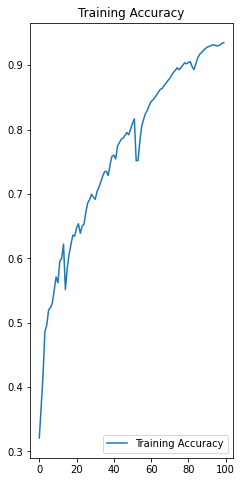

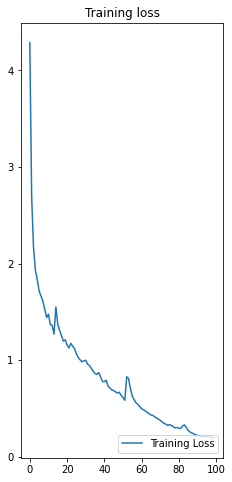

In [34]:
acc = model_history.history['accuracy']
loss = model_history.history['loss']
epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
    
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='lower right')
plt.title('Training loss')

In [35]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [36]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [37]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])

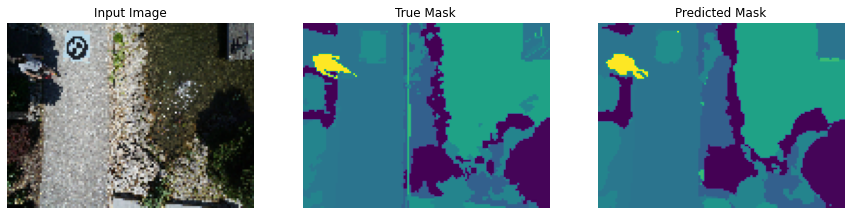

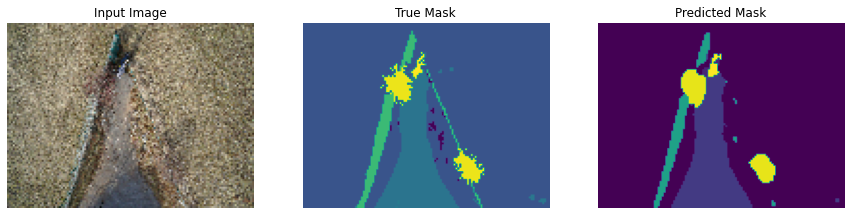

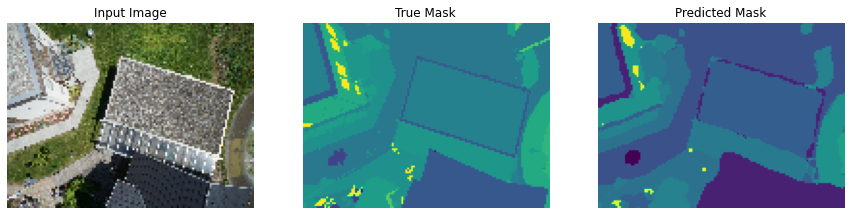

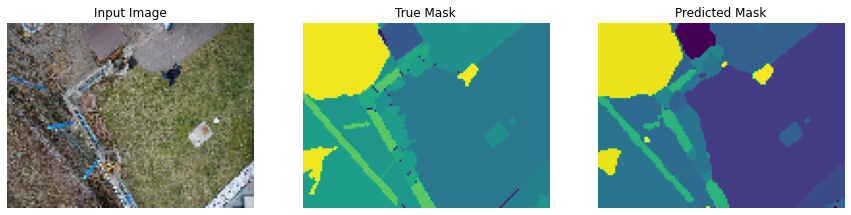

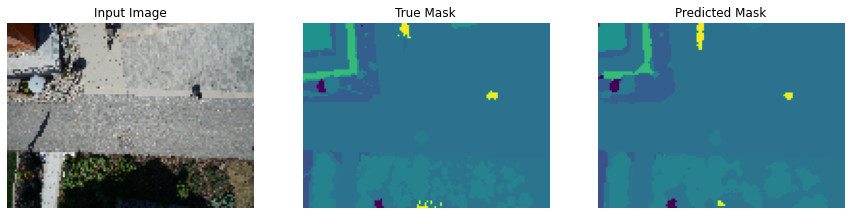

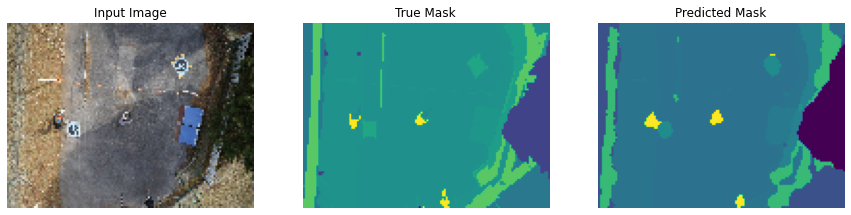

In [38]:
show_predictions(train_dataset, 6)